# **Dependancies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/btc_data')

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


# **Loading Data**

In [ ]:
import pandas as pd

# Đường dẫn đến file btc_data.csv
file_path = '/content/drive/My Drive/Colab Notebooks/btc_data/BTC_Data_2014-2022.csv'

# Đọc file CSV
data = pd.read_csv(file_path)


# Hiển thị 10 dòng đầu tiên
data.head(10)


,Date,priceUSD,size,sentbyaddress,transactions,mining_profitability,sentinusd,transactionfees,median_transaction_fee,confirmationtime,marketcap,transactionvalue,mediantransactionvalue,tweets,google_trends,fee_to_reward,activeaddresses,top100cap
0,2014/04/09,447.110,243742.0,122401,64992,38.678,239212041.0,0.1390,0.0447,8.944,5587996110,4115.0,100.420,8193,11.193,0.502,179274,19.211
1,2014/04/10,407.703,254334.0,124298,67872,31.917,310367120.0,0.0864,0.0408,9.290,5020359905,4876.0,120.946,15039,13.854,0.371,182996,19.166
2,2014/04/11,403.328,223656.0,117926,65563,36.814,292756343.0,0.0858,0.0403,8.521,5068919648,4819.0,108.481,14907,12.997,0.330,169622,19.141
3,2014/04/12,425.310,169964.0,87828,47579,34.498,157264741.0,0.0811,0.0425,8.944,5329088351,3574.0,84.408,7582,9.229,0.226,132283,19.145
4,2014/04/13,415.876,162260.0,94828,50981,34.141,154756367.0,0.0840,0.0416,7.701,5150414718,3332.0,69.681,10674,10.385,0.221,172708,19.131
5,2014/04/14,445.898,216048.0,127969,70026,37.973,253143718.0,0.0977,0.0446,7.461,5628122040,3990.0,115.249,13266,10.754,0.318,183291,19.146
6,2014/04/15,487.666,241539.0,123107,72627,38.650,293892234.0,0.1110,0.0488,7.912,6170470953,4479.0,123.089,14835,11.053,0.362,199054,19.124
7,2014/04/16,517.354,270984.0,114312,68435,40.201,389249585.0,0.1080,0.0517,9.057,6496569317,6046.0,129.799,15790,12.189,0.359,185075,19.146
8,2014/04/17,505.461,223631.0,102596,65021,40.706,385378002.0,0.1170,0.0505,8.521,6281237538,6384.0,102.416,15215,11.471,0.355,157751,19.092
9,2014/04/18,485.296,205478.0,100633,56836,35.818,360602878.0,0.1040,0.0485,9.000,5972292967,6461.0,107.713,14028,9.946,0.304,149452,19.054


# **Model Architecture + Training**

### Best Params: order=(1, 2, 2), seasonal_order=(1, 0, 2, 12) đã tìm được ở Model SARIMAX

In [5]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, LayerNormalization
from keras.callbacks import EarlyStopping
from keras_tuner import HyperModel, RandomSearch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf

# 1. Load and preprocess data
def load_and_preprocess_data(data):
    X = data.drop(columns=['priceUSD', 'Date'])
    y = data['priceUSD']

    n = len(X)
    train_end = int(n * 0.8)
    val_end = int(n * 0.9)

    X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
    y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

    # Fit scaler only on training data
    scaler = MinMaxScaler()
    scaler.fit(y_train.values.reshape(-1, 1))

    y_train_scaled = scaler.transform(y_train.values.reshape(-1, 1))
    y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    return X_train, X_val, X_test, y_train_scaled, y_val_scaled, y_test_scaled, scaler


# 2. Train SARIMAX
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/Training-SRM-LSTM_Ver20'
def train_sarimax(y_train, X_train, save_dir, order=(1, 2, 2), seasonal_order=(1, 0, 2, 12)):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    model_path = os.path.join(save_dir, 'sarimax_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(result, f)
    print(f"SARIMAX model saved to: {model_path}")
    return result

# 3. Calculate residuals
def calculate_residuals(y_train, y_val, y_test, sarimax_result, X_train, X_val, X_test):
    sarimax_pred_train = sarimax_result.fittedvalues
    sarimax_pred_val = sarimax_result.get_forecast(steps=len(y_val), exog=X_val).predicted_mean
    sarimax_pred_test = sarimax_result.get_forecast(steps=len(y_test), exog=X_test).predicted_mean

    residual_train = y_train.flatten() - sarimax_pred_train.values.flatten()
    residual_val = y_val.flatten() - sarimax_pred_val.values.flatten()
    residual_test = y_test.flatten() - sarimax_pred_test.values.flatten()

    return residual_train, residual_val, residual_test, sarimax_pred_train, sarimax_pred_val, sarimax_pred_test

# 4. Định nghĩa LSTM HyperModel
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        # Input shape: (timesteps=1, features=1) theo dữ liệu residual đơn chiều
        inputs = Input(shape=(1, 1))

        x = inputs
        # Số lớp LSTM (1 đến 3 lớp)
        for i in range(hp.Int('num_lstm_layers', 1, 3)):
            return_sequences = (i < hp.get('num_lstm_layers') - 1)  # chỉ các lớp giữa mới return sequences
            units = hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32)
            x = LSTM(units, return_sequences=return_sequences)(x)
            x = Dropout(hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1))(x)

        x = LayerNormalization()(x)
        outputs = Dense(1)(x)

        model = Model(inputs=inputs, outputs=outputs)

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')
        weight_decay = hp.Float('weight_decay', 1e-5, 1e-3, sampling='log')

        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=weight_decay
        )

        model.compile(optimizer=optimizer, loss='mse')
        return model

# 5. Train LSTM with validation
def train_lstm(residual_train, residual_val):
    residual_train_reshaped = residual_train.reshape(residual_train.shape[0], 1, 1)
    residual_val_reshaped = residual_val.reshape(residual_val.shape[0], 1, 1)

    hypermodel = LSTMHyperModel()
    tuner = RandomSearch(
        hypermodel,
        objective='val_loss',
        max_trials=250,
        executions_per_trial=1,
        directory='my_dir',
        project_name='lstm_optimization'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    tuner.search(residual_train_reshaped, residual_train,
                 epochs=300, batch_size=32,
                 validation_data=(residual_val_reshaped, residual_val),
                 callbacks=[early_stopping])

    print("Parameters of all the models that have been run:")
    for trial in tuner.oracle.trials.values():
        print(f"Trial ID: {trial.trial_id}")
        print(f"Parameters: {trial.hyperparameters.values}")
        print(f"Learning Rate: {trial.hyperparameters.get('learning_rate')}")
        print(f"Weight Decay: {trial.hyperparameters.get('weight_decay')}")
        print(f"Score: {trial.score}\n")


        # Lấy best hyperparameters
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Parameters of BEST MODEL:")
    for param in best_hp.values:
        print(f"{param}: {best_hp.get(param)}")

    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

# 6. Combine predictions
def combine_predictions(y_train, y_val, y_test, scaler,
                        sarimax_pred_train, sarimax_pred_val, sarimax_pred_test,
                        lstm_pred_train, lstm_pred_val, lstm_pred_test):
    combined_pred_train = sarimax_pred_train.values.reshape(-1, 1) + lstm_pred_train
    combined_pred_val = sarimax_pred_val.values.reshape(-1, 1) + lstm_pred_val
    combined_pred_test = sarimax_pred_test.values.reshape(-1, 1) + lstm_pred_test

    y_train_original = scaler.inverse_transform(y_train)
    y_val_original = scaler.inverse_transform(y_val)
    y_test_original = scaler.inverse_transform(y_test)

    combined_pred_train_original = scaler.inverse_transform(combined_pred_train)
    combined_pred_val_original = scaler.inverse_transform(combined_pred_val)
    combined_pred_test_original = scaler.inverse_transform(combined_pred_test)

    return (y_train_original, y_val_original, y_test_original,
            combined_pred_train_original, combined_pred_val_original, combined_pred_test_original)

# 7. Evaluate model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, r2, mse, mape

# 8. Main Execution
X_train, X_val, X_test, y_train, y_val, y_test, scaler = load_and_preprocess_data(data)

sarimax_result = train_sarimax(y_train, X_train, save_dir)

residual_train, residual_val, residual_test, sarimax_pred_train, sarimax_pred_val, sarimax_pred_test = calculate_residuals(
    y_train, y_val, y_test, sarimax_result, X_train, X_val, X_test
)

lstm_model = train_lstm(residual_train, residual_val)

lstm_pred_train = lstm_model.predict(residual_train.reshape(residual_train.shape[0], 1, 1)).reshape(-1, 1)
lstm_pred_val = lstm_model.predict(residual_val.reshape(residual_val.shape[0], 1, 1)).reshape(-1, 1)
lstm_pred_test = lstm_model.predict(residual_test.reshape(residual_test.shape[0], 1, 1)).reshape(-1, 1)

(y_train_original, y_val_original, y_test_original,
 combined_pred_train_original, combined_pred_val_original, combined_pred_test_original) = combine_predictions(
    y_train, y_val, y_test, scaler,
    sarimax_pred_train, sarimax_pred_val, sarimax_pred_test,
    lstm_pred_train, lstm_pred_val, lstm_pred_test
)

# Evaluate on test set
mae, rmse, r2, mse, mape = evaluate_model(y_test_original, combined_pred_test_original)

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test R2: {r2}')
print(f'Test MSE: {mse}')
print(f'Test MAPE: {mape}%')

# 9. Display and save results
results = pd.DataFrame({
    'Actual': y_test_original.flatten(),
    'Predicted': combined_pred_test_original.flatten()
})
print(results.head(10))

results_path = os.path.join(save_dir, 'result_predictions_SARIMAX_LSTM_model.csv')
results.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")

# Save Model
lstm_model_path = os.path.join(save_dir, 'SARIMAX_LSTM_model.keras')
lstm_model.save(lstm_model_path)
print(f"Model saved to: {lstm_model_path}")


Trial 250 Complete [00h 01m 52s]
val_loss: 1.8256691713958162e-09

Best val_loss So Far: 6.719220319029162e-11
Total elapsed time: 07h 44m 12s
Parameters of all the models that have been run:
Trial ID: 000
Parameters: {'num_lstm_layers': 1, 'lstm_units_0': 192, 'dropout_rate_0': 0.5, 'learning_rate': 0.0007469897443359323, 'weight_decay': 0.00022622191709800314}
Learning Rate: 0.0007469897443359323
Weight Decay: 0.00022622191709800314
Score: 2.157786394008099e-09

Trial ID: 001
Parameters: {'num_lstm_layers': 2, 'lstm_units_0': 256, 'dropout_rate_0': 0.1, 'learning_rate': 0.0006504039604428609, 'weight_decay': 0.00013495506592223672, 'lstm_units_1': 32, 'dropout_rate_1': 0.1}
Learning Rate: 0.0006504039604428609
Weight Decay: 0.00013495506592223672
Score: 2.623954031832909e-08

Trial ID: 002
Parameters: {'num_lstm_layers': 3, 'lstm_units_0': 192, 'dropout_rate_0': 0.4, 'learning_rate': 0.00020210083230285273, 'weight_decay': 2.4359196179105857e-05, 'lstm_units_1': 256, 'dropout_rate_1'

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test MAE: 0.6412469420040752
Test RMSE: 0.6627903288959037
Test R2: 0.9999999952888061
Test MSE: 0.4392910200779403
Test MAPE: 0.002840127652908234%
    Actual     Predicted
0  43854.0  43854.538994
1  43922.0  43922.536067
2  44331.0  44331.549303
3  43185.0  43185.522581
4  42333.0  42333.504280
5  42336.0  42336.502636
6  42232.0  42232.505289
7  43867.0  43867.544147
8  43998.0  43998.551675
9  42666.0  42666.522164
Predictions saved to: /content/drive/My Drive/Colab Notebooks/btc_data/Training-SRM-LSTM_Ver20/result_predictions_SARIMAX_LSTM_model.csv
Model saved to: /content/drive/My Drive/Colab Notebooks/btc_data/Training-SRM-LSTM_Ver20/SARIMAX_LSTM_model.keras


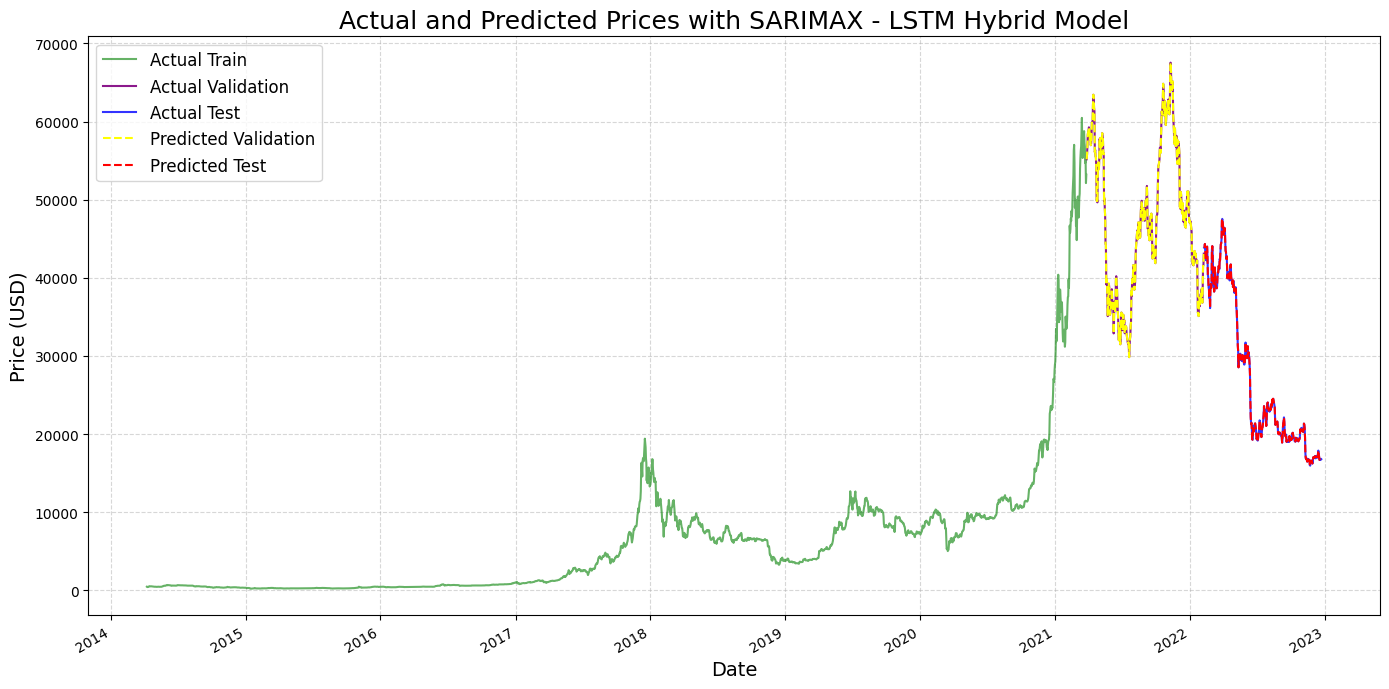

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


# Các biến
train_dates = pd.to_datetime(data['Date'].iloc[:len(y_train)])
val_dates = pd.to_datetime(data['Date'].iloc[len(y_train):len(y_train)+len(y_val)])
test_dates = pd.to_datetime(data['Date'].iloc[len(y_train)+len(y_val):])

plt.figure(figsize=(14, 7))

# Actual Train
plt.plot(train_dates, y_train_original.flatten(), label='Actual Train', color='green', alpha=0.6)

# Actual Validation
plt.plot(val_dates, y_val_original.flatten(), label='Actual Validation', color='purple', alpha=0.9)

# Actual Test
plt.plot(test_dates, y_test_original.flatten(), label='Actual Test', color='blue', alpha=0.8)

# Predicted Train (SARIMAX + LSTM)
#plt.plot(train_dates, combined_pred_train_original.flatten(), label='Predicted Train', linestyle='--', color='lime')

# Predicted Validation (SARIMAX + LSTM)
plt.plot(val_dates, combined_pred_val_original.flatten(), label='Predicted Validation', linestyle='--', color='yellow')

# Predicted Test (SARIMAX + LSTM)
plt.plot(test_dates, combined_pred_test_original.flatten(), label='Predicted Test', linestyle='--', color='red')

# Định dạng trục x (theo năm)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.title('Actual and Predicted Prices with SARIMAX - LSTM Hybrid Model', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


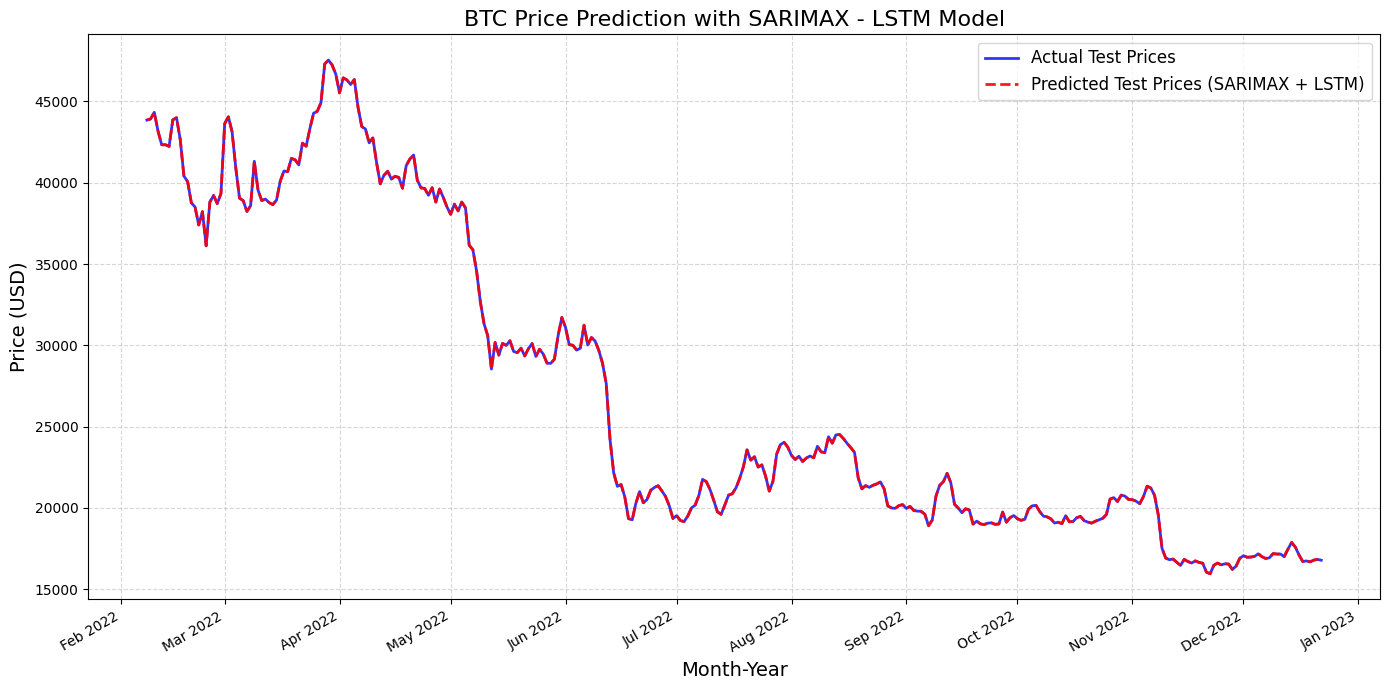

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 'data' có cột 'Date'
data['Date'] = pd.to_datetime(data['Date'])

# Chỉ số tách 10% test
split_index = int(len(data) * 0.9)

# Lấy dates tập test
dates_test = data['Date'].iloc[split_index:].reset_index(drop=True)

# Chuyển y_test_original và combined_pred_test_original thành dạng 1D array nếu chưa
y_test_vals = y_test_original.flatten()
pred_test_vals = combined_pred_test_original.flatten()

# Nếu độ dài có thể không khớp, cắt cho khớp với dates_test
min_len = min(len(dates_test), len(y_test_vals), len(pred_test_vals))
dates_test = dates_test.iloc[:min_len]
y_test_vals = y_test_vals[:min_len]
pred_test_vals = pred_test_vals[:min_len]

plt.figure(figsize=(14, 7))

# Vẽ giá thực tế tập test
plt.plot(dates_test, y_test_vals,
         label='Actual Test Prices', color='blue', linewidth=2, alpha=0.8)

# Vẽ giá dự đoán tập test từ mô hình SARIMAX + LSTM
plt.plot(dates_test, pred_test_vals,
         label='Predicted Test Prices (SARIMAX + LSTM)',
         color='red', linestyle='--', linewidth=2, alpha=0.9)

# Định dạng trục x hiển thị tháng-năm, cách 1 tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

# Tiêu đề, nhãn trục, chú thích
plt.title('BTC Price Prediction with SARIMAX - LSTM Model', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)

# Lưới, căn chỉnh bố cục
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


In [8]:
y_test_vals

array([43854., 43922., 44331., 43185., 42333., 42336., 42232., 43867.,
       43998., 42666., 40411., 40065., 38767., 38507., 37400., 38221.,
       36117., 38813., 39217., 38714., 39337., 43632., 44055., 43130.,
       40909., 39056., 38897., 38233., 38584., 41317., 39547., 38901.,
       38996., 38776., 38654., 38933., 40098., 40722., 40678., 41493.,
       41413., 41100., 42431., 42247., 43324., 44274., 44390., 44930.,
       47302., 47546., 47240., 46673., 45524., 46450., 46321., 46041.,
       46345., 44634., 43453., 43305., 42453., 42755., 41238., 39931.,
       40459., 40705., 40226., 40399., 40318., 39660., 41050., 41462.,
       41706., 40149., 39684., 39645., 39226., 39694., 38810., 39615.,
       39101., 38509., 38058., 38684., 38264., 38809., 38452., 36159.,
       35876., 34566., 32700., 31334., 30593., 28537., 30174., 29393.,
       30116., 29997., 30281., 29621., 29546., 29822., 29343., 29797.,
       30108., 29312., 29758., 29457., 28904., 28888., 29144., 30589.,
      

In [9]:
pred_test_vals

array([43854.53899364, 43922.53606662, 44331.54930349, 43185.52258088,
       42333.50428014, 42336.50263643, 42232.5052894 , 43867.54414672,
       43998.55167489, 42666.52216423, 40411.48156238, 40065.47711576,
       38767.46855377, 38507.45399533, 37400.44083867, 38221.44987732,
       36117.43030352, 38813.45634004, 39217.46064003, 38714.45377277,
       39337.46367093, 43632.54490113, 44055.54812352, 43130.52898986,
       40909.4873181 , 39056.45801304, 38897.45408596, 38233.44801276,
       38584.45198382, 41317.49456843, 39547.4638518 , 38901.45498351,
       38996.45578143, 38776.45260055, 38654.45189872, 38933.45480198,
       40098.47322491, 40722.48293056, 40678.48180886, 41493.49572043,
       41413.49318153, 41100.49007118, 42431.5130266 , 42247.51173637,
       43324.53779466, 44274.56242384, 44390.56087267, 44930.57526884,
       47302.65711426, 47546.66044182, 47240.65391112, 46673.63649717,
       45524.60009569, 46450.62749986, 46321.61884837, 46041.61123123,
      